In [1]:
#auto reload jupyter to update notebook w.r.t changes in other linked files:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
#from xgboost.testing import root_mean_square

from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


from train_and_evaluate_sklearn import load_train_test_data
from preprocessing import preprocess_data, train_test_split

Null values after aggregation to median
time                0
lat                 0
lon                 0
clf                 0
lwp                 0
blh                 0
cape                0
mlspf               0
mslhf               0
msshf               0
q700                0
q850                0
rh700               0
rh850               0
sst                 0
t700                0
t850                0
tcwv                0
u10                 0
u700                0
u850                0
v10                 0
v700                0
v850                0
w700                0
w850                0
Terra_descending    0
lsm                 0
eis                 0
lnNd                0
dtype: int64
Null Values:
time                0
lat                 0
lon                 0
clf                 0
lwp                 0
blh                 0
cape                0
mlspf               0
mslhf               0
msshf               0
q700                0
q850                0
rh700     

In [3]:
#Define the predictand
predictands = 'both'  # choose - 'clf', 'lwp', or 'both'

df_preprocessed, predictors, predictands = (preprocess_data
    (
        scalertype='minmax', #best performance 'minmax' scaler
        outlier_method=None, #best performance 'iqr' outlier method
        scale_predictands=True,
        selected_predictands=predictands,
  ))
#df_train, df_test, X_train, y_train, X_test, y_test, predictors, predictands = load_train_test_data(predictands=predictands)


Preprocessed data returned.
 Scaled Data: minmax scaler applied.
 Outlier removal method: None.
 Predictands: ['clf', 'lwp']


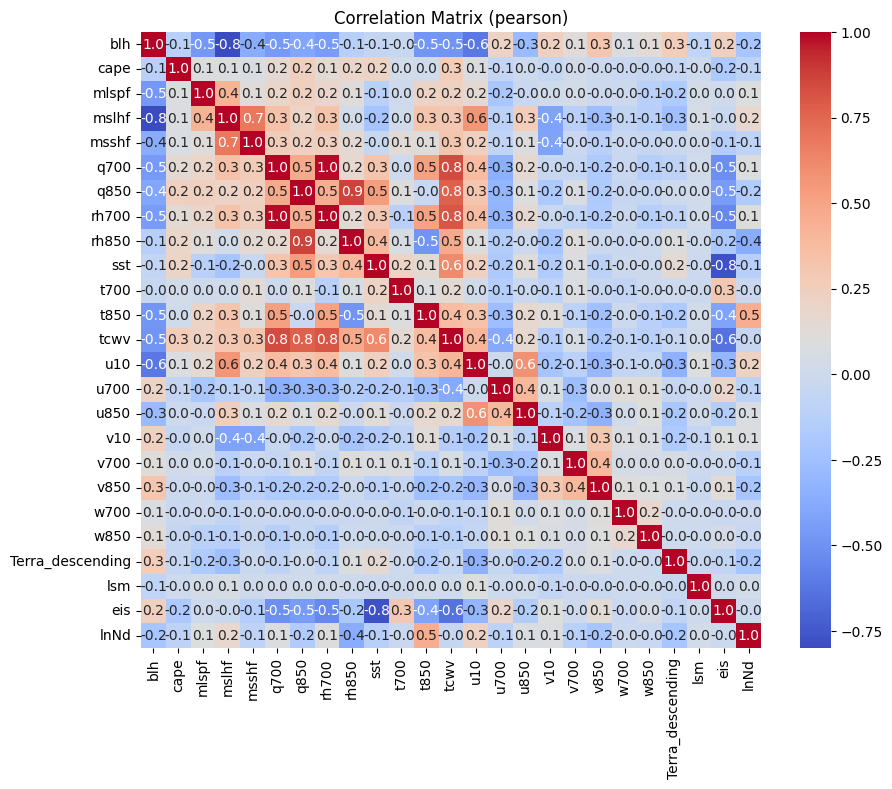

Pairs with |correlation| > 0.7:
blh & mslhf: -0.80
q700 & rh700: 0.99
q700 & tcwv: 0.84
q850 & rh850: 0.87
q850 & tcwv: 0.77
rh700 & tcwv: 0.81
sst & eis: -0.77


In [74]:
from preprocessing import compute_correlation
compute_correlation(df_preprocessed)

In [39]:
#REMOVE (SOME) CORRELATED PREDICTORS
# df_preprocessed=df_preprocessed.drop(columns=['mslhf','rh700','rh850','tcwv'])
#
#
# predictors = [col for col in df_preprocessed.columns if col not in ['clf','lwp','time', 'lat', 'lon', 'cat','dog']]


In [4]:

df_train, df_test, X_train, y_train, X_test, y_test = train_test_split(
    df_preprocessed=df_preprocessed,
    predictors=predictors,
    predictands=predictands,
    train_fraction=0.75
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Convert pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f'train_loader: {train_loader} \n test_loader: {test_loader}' )
print(f'size of train_loader: {len(train_loader)} \n size of test_loader: {len(test_loader)}')

X_train shape: (197145, 25), y_train shape: (197145, 2)
train_loader: <torch.utils.data.dataloader.DataLoader object at 0x771ca742d850> 
 test_loader: <torch.utils.data.dataloader.DataLoader object at 0x771ca734d810>
size of train_loader: 3081 
 size of test_loader: 949


Neural Network Architecture

In [5]:
class MultiTargetRegressor(nn.Module):
    """Neural network for multi-target regression"""
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            # Input layer to first hidden layer
            nn.Linear(input_size, 32),
            nn.ReLU(),

            # First hidden layer to second hidden layer
            nn.Linear(32, 16),
            nn.ReLU(),

            # second hidden layer to third hidden layer
            nn.Linear(16, 10),
            nn.ReLU(),

            # third hidden layer to output layer
            nn.Linear(10, output_size)
        )

        # Initialize weights using Kaiming He initialization for ReLU
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        """Defines forward pass through network"""
        return self.layers(x)

Model Training Function:

In [6]:
def train_model(model, train_loader, test_loader, num_epochs=100):
    """Training loop with validation monitoring"""
    # Loss function and optimizer
    learning_rate = 0.005
    #loss_function = nn.MSELoss()
    loss_function = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    # Track losses for visualization
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(X_batch)  # Forward pass
            loss = loss_function(outputs, y_batch)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            epoch_train_loss += loss.item()

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = loss_function(outputs, y_batch)
                epoch_val_loss += loss.item()

        # Calculate average losses
        train_loss = epoch_train_loss / len(train_loader)
        val_loss = epoch_val_loss / len(test_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}')

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

    return train_losses, val_losses


In [7]:
#TIME CONSUMING STEP
#Model Training

input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MultiTargetRegressor(input_size, output_size)

# Train model
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=30
)

Epoch 1/30 | Train Loss: 0.0173 | Val Loss: 0.0151 | LR: 0.005000
Epoch 1/30 | Train Loss: 0.0173 | Val Loss: 0.0151
Epoch 2/30 | Train Loss: 0.0151 | Val Loss: 0.0151 | LR: 0.005000
Epoch 2/30 | Train Loss: 0.0151 | Val Loss: 0.0151
Epoch 3/30 | Train Loss: 0.0147 | Val Loss: 0.0146 | LR: 0.005000
Epoch 3/30 | Train Loss: 0.0147 | Val Loss: 0.0146
Epoch 4/30 | Train Loss: 0.0145 | Val Loss: 0.0147 | LR: 0.005000
Epoch 4/30 | Train Loss: 0.0145 | Val Loss: 0.0147
Epoch 5/30 | Train Loss: 0.0143 | Val Loss: 0.0144 | LR: 0.005000
Epoch 5/30 | Train Loss: 0.0143 | Val Loss: 0.0144
Epoch 6/30 | Train Loss: 0.0142 | Val Loss: 0.0144 | LR: 0.005000
Epoch 6/30 | Train Loss: 0.0142 | Val Loss: 0.0144
Epoch 7/30 | Train Loss: 0.0141 | Val Loss: 0.0142 | LR: 0.005000
Epoch 7/30 | Train Loss: 0.0141 | Val Loss: 0.0142
Epoch 8/30 | Train Loss: 0.0141 | Val Loss: 0.0140 | LR: 0.005000
Epoch 8/30 | Train Loss: 0.0141 | Val Loss: 0.0140
Epoch 9/30 | Train Loss: 0.0140 | Val Loss: 0.0139 | LR: 0.00500

Model Evaluation:

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, X_test_tensor, y_test):
    """Generate predictions and calculate metrics"""
    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)

    # Convert to numpy for sklearn metrics
    y_pred = y_pred_tensor.numpy()

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Method #2 from search results
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Display metrics
    print("\nFinal Model Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")  # Added from search result [1][2]
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return y_pred

Visualisation

In [9]:
 def plot_loss_curves(train_losses, val_losses):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Loss Curves when predictands = {predictands}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Execution

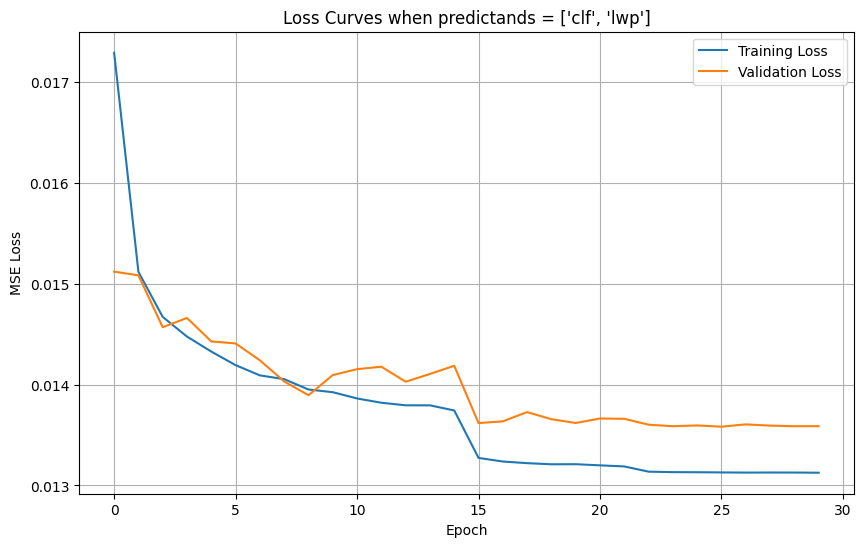


Final Model Evaluation:
MSE: 0.0272
RMSE: 0.1648
MAE: 0.1147
R²: 0.4032


array([[0.86403227, 0.08732092],
       [0.9139844 , 0.09278406],
       [0.8939079 , 0.09619008],
       ...,
       [0.7221443 , 0.18843243],
       [0.5731503 , 0.10652653],
       [0.3891541 , 0.07558873]], dtype=float32)

In [10]:
 #Visualize training progress
plot_loss_curves(train_losses=train_losses, val_losses=val_losses)

# Final evaluation
evaluate_model(model=model, X_test_tensor=X_test_tensor, y_test=y_test)
#y_pred = evaluate_model(model, X_test_tensor, y_test)

In [71]:
def permutation_feature_importance(model, X, y, metric, n_repeats=5):
    """
    Measures the importance of each input variable by repeatedly shuffling its values in the test data,
    evaluating the increase in prediction error (e.g., MSE). A larger increase means the variable is more important
    for the model's predictions. The process is repeated several times per variable for reliability.
    """

    model.eval()
    # Step 1: Get the model's baseline performance on the unshuffled test data
    with torch.no_grad():
        baseline_predictions = model(X).detach().cpu().numpy()
    if isinstance(y, torch.Tensor):
        y_true = y.cpu().numpy()
    else:
        y_true = y
    baseline_error = metric(y_true, baseline_predictions)
    feature_importances = np.zeros(X.shape[1])

    # Step 2: For each feature, shuffle its values and measure the increase in error
    for feature_idx in range(X.shape[1]):
        shuffled_errors = []
        for _ in range(n_repeats):
            X_shuffled = X.clone()
            shuffle_indices = torch.randperm(X.shape[0])
            X_shuffled[:, feature_idx] = X_shuffled[shuffle_indices, feature_idx]
            with torch.no_grad():
                shuffled_predictions = model(X_shuffled).detach().cpu().numpy()
            shuffled_error = metric(y_true, shuffled_predictions)
            shuffled_errors.append(shuffled_error)
        # Step 3: Calculate importance as the average increase in error due to shuffling this feature
        feature_importances[feature_idx] = np.mean(shuffled_errors) - baseline_error
    # Return both importances and baseline error for percentage calculation
    return feature_importances, baseline_error



Permutation Feature Importances (higher = more important):
rh850: 0.0224 (Error Increase: 67.25%)
tcwv: 0.0159 (Error Increase: 47.69%)
t850: 0.0132 (Error Increase: 39.52%)
blh: 0.0087 (Error Increase: 26.03%)
eis: 0.0081 (Error Increase: 24.41%)
lnNd: 0.0078 (Error Increase: 23.36%)
q700: 0.0072 (Error Increase: 21.68%)
q850: 0.0069 (Error Increase: 20.78%)
sst: 0.0060 (Error Increase: 18.08%)
mlspf: 0.0044 (Error Increase: 13.08%)
u850: 0.0026 (Error Increase: 7.70%)
cape: 0.0023 (Error Increase: 6.81%)
u10: 0.0021 (Error Increase: 6.19%)
rh700: 0.0019 (Error Increase: 5.84%)
v10: 0.0018 (Error Increase: 5.26%)
t700: 0.0016 (Error Increase: 4.93%)
msshf: 0.0016 (Error Increase: 4.88%)
mslhf: 0.0012 (Error Increase: 3.60%)
v850: 0.0011 (Error Increase: 3.34%)
Terra_descending: 0.0011 (Error Increase: 3.20%)
u700: 0.0008 (Error Increase: 2.38%)
w850: 0.0007 (Error Increase: 1.96%)
v700: 0.0002 (Error Increase: 0.68%)
w700: 0.0001 (Error Increase: 0.21%)
lsm: 0.0000 (Error Increase: 0

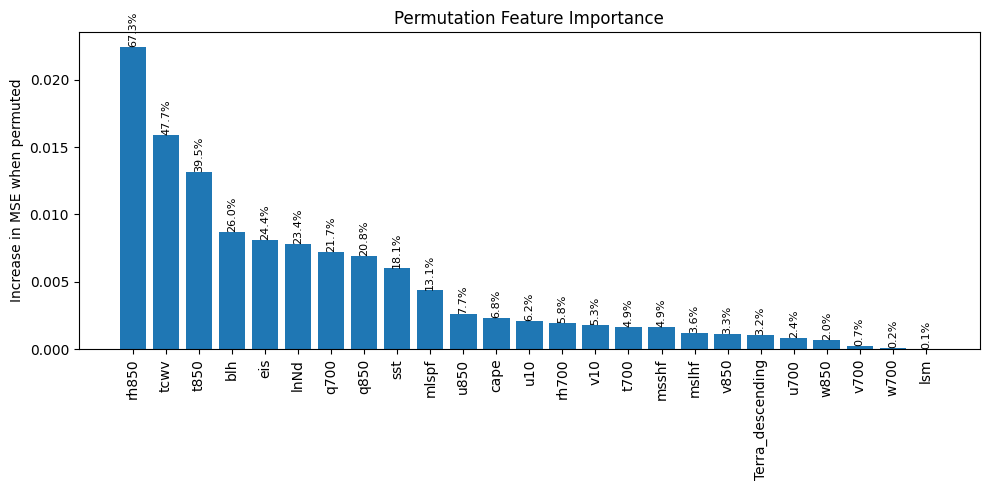

In [72]:
       # Calculate and display feature importances after model evaluation
importances, baseline_error = permutation_feature_importance(
    model, X_test_tensor, y_test.values, mean_squared_error, n_repeats=5
)
# Calculate percentage increase for each feature
percent_increase = 100 * importances / baseline_error
# Sort and print
sorted_idx = np.argsort(importances)[::-1]

print("\nPermutation Feature Importances (higher = more important):")
for i in sorted_idx:
    print(f"{predictors[i]}: {importances[i]:.4f} (Error Increase: {percent_increase[i]:.2f}%)")

# Optionally, plot the importances
plt.figure(figsize=(10, 5))
bars = plt.bar([predictors[i] for i in sorted_idx], importances[sorted_idx])
plt.xticks(rotation=90)
plt.ylabel('Increase in MSE when permuted')
plt.title('Permutation Feature Importance')
plt.tight_layout()
# Annotate bars with percentage increase
for bar, perc in zip(bars, percent_increase[sorted_idx]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{perc:.1f}%',
             ha='center', va='bottom', fontsize=8, rotation=90)
plt.show()

In [20]:
def print_model_structure(model, input_size, output_size):
    neuron_counts = [input_size]  # Start with input size
    linear_layers = []

    # Collect neuron counts for each nn.Linear layer
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            neuron_counts.append(layer.out_features)
            linear_layers.append(layer)

    # Print neurons per layer
    print("Model Structure:")
    print(f"Input layer: {neuron_counts[0]} neurons")
    for i, n in enumerate(neuron_counts[1:-1], 1):
        print(f"Hidden layer {i}: {n} neurons")
    print(f"Output layer: {neuron_counts[-1]} neurons")

    # Print total neurons (excluding input layer if you want only trainable neurons)
    total_neurons = sum(neuron_counts)
    print(f"\nTotal number of neurons (including input and output): {total_neurons}")

    # Print number of layers
    print(f"Number of layers (Linear): {len(linear_layers)}")
    print(f"Number of hidden layers: {len(linear_layers) - 1}")

# Example usage:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MultiTargetRegressor(input_size, output_size)
print_model_structure(model, input_size, output_size)


Model Structure:
Input layer: 25 neurons
Hidden layer 1: 32 neurons
Hidden layer 2: 16 neurons
Hidden layer 3: 10 neurons
Output layer: 2 neurons

Total number of neurons (including input and output): 85
Number of layers (Linear): 4
Number of hidden layers: 3


In [21]:
import numpy as np

def feature_importance(model, X, y, metric, n_repeats=5):
    baseline_score = metric(y, model(X).detach().numpy())
    importances = np.zeros(X.shape[1])

    for col in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.clone()
            idx = torch.randperm(X.shape[0])
            X_permuted[:, col] = X_permuted[idx, col]
            score = metric(y, model(X_permuted).detach().numpy())
            scores.append(score)
        importances[col] = np.mean(scores) - baseline_score
    return importances

# Usage:
model.eval()
importances = feature_importance(
    model, X_test_tensor, y_test.values, mean_squared_error
)
for i, imp in enumerate(importances):
    print(f"{i} {predictors[i]}: Significance {imp:.4f}")

0 blh: Significance 0.0029
1 cape: Significance 0.0006
2 mlspf: Significance 0.0042
3 mslhf: Significance 0.0055
4 msshf: Significance 0.0037
5 q700: Significance 0.0251
6 q850: Significance -0.0073
7 rh700: Significance -0.0005
8 rh850: Significance -0.0053
9 sst: Significance -0.0009
10 t700: Significance 0.0009
11 t850: Significance 0.0008
12 tcwv: Significance 0.0135
13 u10: Significance -0.0018
14 u700: Significance 0.0111
15 u850: Significance -0.0008
16 v10: Significance -0.0010
17 v700: Significance 0.0011
18 v850: Significance 0.0019
19 w700: Significance -0.0001
20 w850: Significance 0.0009
21 Terra_descending: Significance -0.0089
22 lsm: Significance -0.0001
23 eis: Significance -0.0119
24 lnNd: Significance 0.0061


In [22]:
# If not installed, uncomment the next line:
# !pip install torchsummary

from torchsummary import summary

def visualize_model_summary(model, input_size):
    # input_size should be a tuple without batch size, e.g. (number_of_features,)
    summary(model, input_size)


# Example usage:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MultiTargetRegressor(input_size, output_size)

visualize_model_summary(model, input_size=(X_train.shape[1],))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             832
              ReLU-2                   [-1, 32]               0
            Linear-3                   [-1, 16]             528
              ReLU-4                   [-1, 16]               0
            Linear-5                   [-1, 10]             170
              ReLU-6                   [-1, 10]               0
            Linear-7                    [-1, 2]              22
Total params: 1,552
Trainable params: 1,552
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


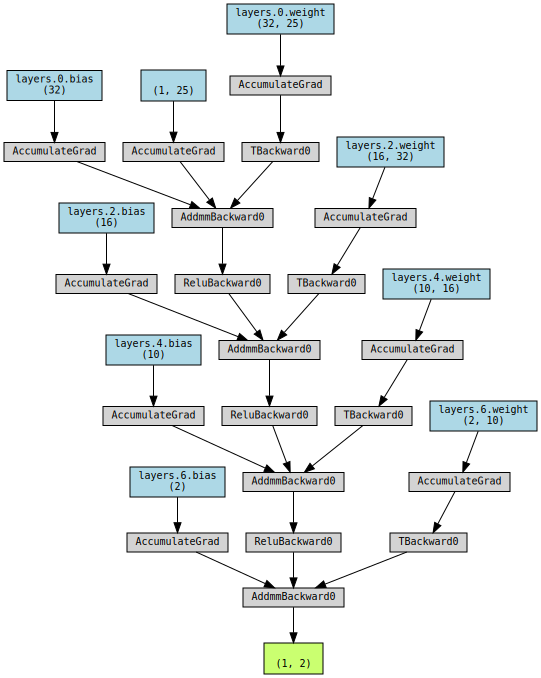

In [23]:
#Hard to interpret this diagram
# Install torchviz if not already installed
# !pip install torchviz

from torchviz import make_dot
import torch

def visualize_model(model, input_size):
    # Create a dummy input tensor with the correct shape
    x = torch.randn(1, input_size, requires_grad=True)
    y = model(x)
    # Create a visualization of the computation graph
    dot = make_dot(y, params=dict(model.named_parameters()))
    return dot


input_size = X_train.shape[1]
output_size = y_train.shape[1]
model = MultiTargetRegressor(input_size, output_size)

# Example usage:
dot = visualize_model(model, input_size)
#dot.render("model_architecture", format="png")  # Saves to file
dot  # Display in Jupyter notebook


In [24]:
#VERY TIME CONSUMING STEP
#HYPER-PARAMETER TUNING: GRID SEARCH

import torch
import torch.optim as optim

# Define your hyperparameter grid
param_grid = {
    'lr': [0.01, 0.001],
    'batch_size': [32, 64],
    'hidden1': [128, 256]
}

from itertools import product

best_val_loss = float('inf')
best_params = None

for lr, batch_size, hidden1 in product(param_grid['lr'], param_grid['batch_size'], param_grid['hidden1']):
    # Prepare data loaders with batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Define model with current hidden layer size
    model = MultiTargetRegressor(input_size, output_size)
    # Optionally, modify your model to accept hidden1 as a parameter

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Train for a few epochs (e.g., 5 for speed)
    for epoch in range(5):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = {'lr': lr, 'batch_size': batch_size, 'hidden1': hidden1}

print("Best params:", best_params)
print("Best validation loss:", best_val_loss)


KeyboardInterrupt: 

In [10]:
#VERY TIME CONSUMING STEP
#HYPER-PARAMETER TUNING: RANDOM SEARCH

import random
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np

# Define the hyperparameter space
param_space = {
    'lr': [1e-3, 5e-4],#, 1e-4, 5e-5],
    'batch_size': [16, 32, 64],#, 128],
    'num_epochs': [20],
    # more hyperparameters as needed
}

n_trials = 10  # Number of random samples

best_val_loss = float('inf')
best_params = None

for trial in range(n_trials):
    # Randomly sample hyperparameters
    lr = random.choice(param_space['lr'])
    batch_size = random.choice(param_space['batch_size'])
    num_epochs = random.choice(param_space['num_epochs'])

    # Create new dataloaders for this batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model
    model = MultiTargetRegressor(input_size, output_size)

    # Set optimizer with sampled learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train model (use your train_model function)
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        num_epochs=num_epochs
    )

    # Use the last validation loss as the metric
    final_val_loss = val_losses[-1]

    print(f"Trial {trial+1}: lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}, val_loss={final_val_loss:.4f}")

    # Track the best hyperparameters
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_params = {
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs
        }

print("Best hyperparameters:", best_params)
print("Best validation loss:", best_val_loss)


/home/sparashar/Installed/miniconda3/envs/calisma/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 0.6257 | Val Loss: 0.5796
Epoch 2/20 | Train Loss: 0.5986 | Val Loss: 0.5750
Epoch 3/20 | Train Loss: 0.5926 | Val Loss: 0.5656
Epoch 4/20 | Train Loss: 0.5887 | Val Loss: 0.5591
Epoch 5/20 | Train Loss: 0.5880 | Val Loss: 0.5595
Epoch 6/20 | Train Loss: 0.5872 | Val Loss: 0.5708
Epoch 7/20 | Train Loss: 0.5843 | Val Loss: 0.5594
Epoch 8/20 | Train Loss: 0.5829 | Val Loss: 0.5614
Epoch 9/20 | Train Loss: 0.5821 | Val Loss: 0.5490
Epoch 10/20 | Train Loss: 0.5815 | Val Loss: 0.5665
Epoch 11/20 | Train Loss: 0.5821 | Val Loss: 0.5599
Epoch 12/20 | Train Loss: 0.5804 | Val Loss: 0.5552
Epoch 13/20 | Train Loss: 0.5808 | Val Loss: 0.5565
Epoch 14/20 | Train Loss: 0.5791 | Val Loss: 0.5682
Epoch 15/20 | Train Loss: 0.5785 | Val Loss: 0.5807
Epoch 16/20 | Train Loss: 0.5488 | Val Loss: 0.5371
Epoch 17/20 | Train Loss: 0.5449 | Val Loss: 0.5338
Epoch 18/20 | Train Loss: 0.5439 | Val Loss: 0.5328
Epoch 19/20 | Train Loss: 0.5435 | Val Loss: 0.5341
Epoch 20/20 | Train L

Best Hyperparameters when predictand = both:
Best hyperparameters: {'lr': 5e-05, 'batch_size': 64, 'num_epochs': 10}
Best validation loss: 0.3247509590034411


# Feature Importance Analysis

